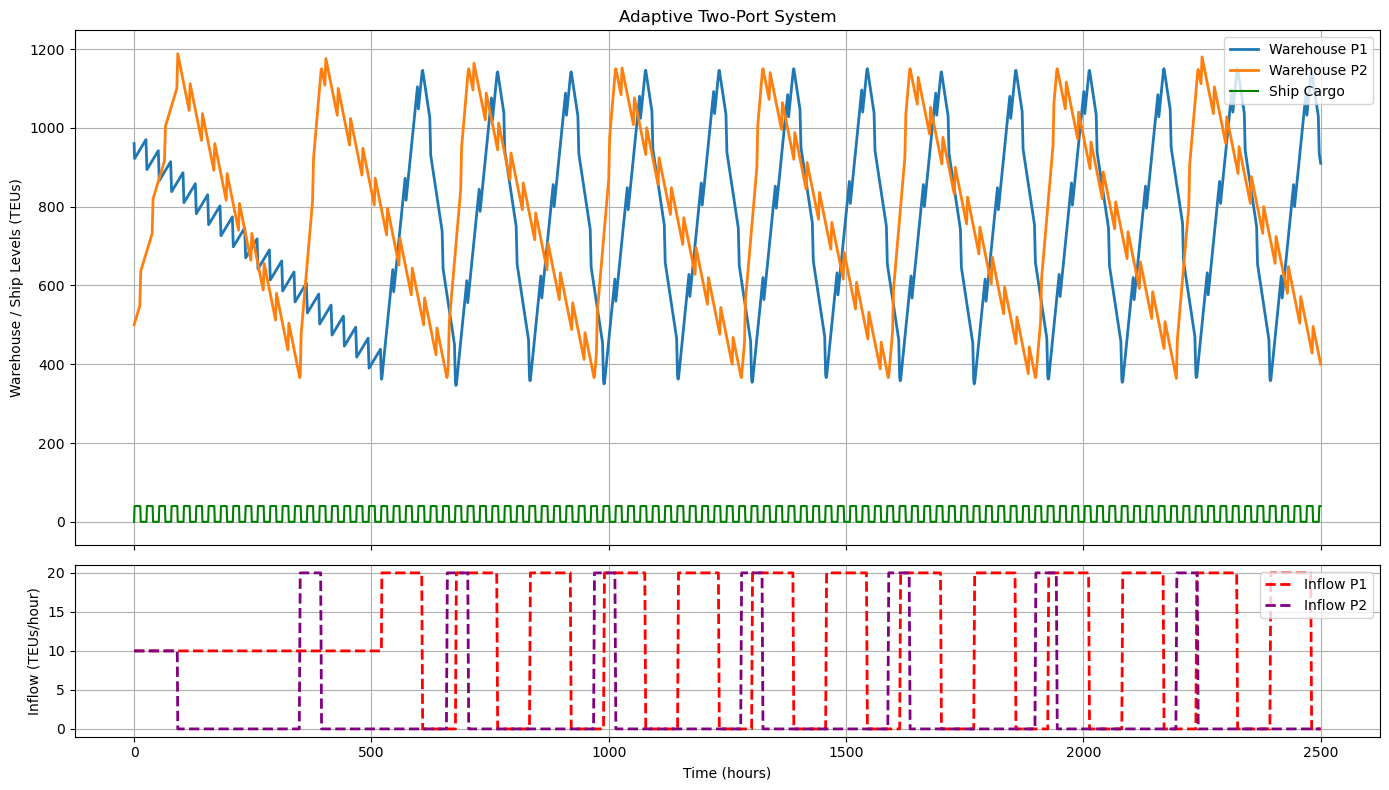

In [185]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
T = 25 * 100
W1_max, W2_max = 1500, 1500
I1_max, I2_max = 20, 20
I1_init, I2_init = 10, 10
O1, O2 = 8, 6
L1, L2 = 40, 30
U1, U2 = 80, 60
C_max = 1000
travel_time = 12
delta = 10

# State Arrays
w1 = np.zeros(T+1)
w2 = np.zeros(T+1)
I1 = np.zeros(T+1)
I2 = np.zeros(T+1)
c = np.zeros(T+1)
state = [""] * (T+1)

# Initial Conditions
w1[0] = 1000
w2[0] = 500
I1[0] = I1_init
I2[0] = I2_init
c[0] = 0
current_state = "Dock_P1"
travel_counter = 0
state[0] = current_state

# Logic Functions
def update_inflow(w, W_max, I, I_max, delta):
    utilization = w / W_max
    if utilization < 0.25:
        return min(I + delta, I_max)
    elif utilization > 0.75:
        return max(I - delta, 0)
    return I

def load_from_port(w, c, L, C_max):
    amount = min(L, w, C_max - c)
    return w - amount, c + amount, amount

def unload_to_port(w, c, U, W_max):
    amount = min(U, c, W_max - w)
    return w + amount, c - amount, amount

def update_warehouse(w, inflow, outflow, unload_amt, load_amt, W_max):
    return min(W_max, max(0, w + inflow - outflow + unload_amt - load_amt))

def update_ship_state(state, counter):
    if state.startswith("Travel"):
        counter -= 1
        if counter == 0:
            return ("Dock_P2" if state == "Travel_P1_to_P2" else "Dock_P1"), 0
        return state, counter
    elif state == "Dock_P1":
        return "Travel_P1_to_P2", travel_time
    elif state == "Dock_P2":
        return "Travel_P2_to_P1", travel_time
    return state, counter

# Simulation Loop
for t in range(T):
    l1 = u2 = 0
    c[t+1] = c[t]

    if current_state == "Dock_P1":
        w1[t], c[t+1], l1 = load_from_port(w1[t], c[t], L1, C_max)
        current_state, travel_counter = update_ship_state(current_state, travel_counter)
    elif current_state == "Travel_P1_to_P2":
        current_state, travel_counter = update_ship_state(current_state, travel_counter)
    elif current_state == "Dock_P2":
        w2[t], c[t+1], u2 = unload_to_port(w2[t], c[t], U2, W2_max)
        current_state, travel_counter = update_ship_state(current_state, travel_counter)
    elif current_state == "Travel_P2_to_P1":
        current_state, travel_counter = update_ship_state(current_state, travel_counter)

    state[t+1] = current_state
    I1[t+1] = update_inflow(w1[t], W1_max, I1[t], I1_max, delta)
    I2[t+1] = update_inflow(w2[t], W2_max, I2[t], I2_max, delta)
    w1[t+1] = update_warehouse(w1[t], I1[t], O1, 0, l1, W1_max)
    w2[t+1] = update_warehouse(w2[t], I2[t], O2, u2, 0, W2_max)

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Warehouse Levels and Ship Cargo
ax1.plot(w1, label="Warehouse P1", linewidth=2)
ax1.plot(w2, label="Warehouse P2", linewidth=2)
ax1.plot(c, label="Ship Cargo", color='green', linewidth=1.5)
ax1.set_ylabel("Warehouse / Ship Levels (TEUs)")
ax1.set_title("Adaptive Two-Port System")
ax1.grid(True)
ax1.legend(loc='upper right')

# Inflow Rates
ax2.plot(I1, label="Inflow P1", linestyle='--', color='red', linewidth=2)
ax2.plot(I2, label="Inflow P2", linestyle='--', color='purple', linewidth=2)
ax2.set_xlabel("Time (hours)")
ax2.set_ylabel("Inflow (TEUs/hour)")
ax2.grid(True)
ax2.legend(loc='upper right')

plt.tight_layout()
# plt.savefig("Two_Port_Time.pdf")
plt.show()


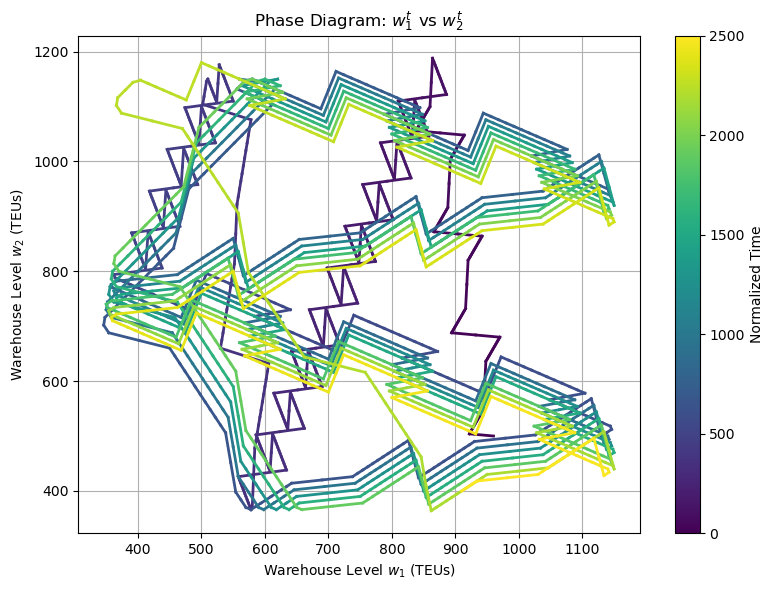

In [186]:
# Normalize time for color gradient
t_norm = np.linspace(0, 1, len(w1))

# Create phase plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot segments with color progression
for i in range(len(w1) - 1):
    ax.plot(w1[i:i+2], w2[i:i+2], color=plt.cm.viridis(t_norm[i]), linewidth=2)

# Colorbar setup
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Normalized Time')

# Labels and formatting
ax.set_xlabel(r'Warehouse Level $w_1$ (TEUs)')
ax.set_ylabel(r'Warehouse Level $w_2$ (TEUs)')
ax.set_title(r'Phase Diagram: $w_1^t$ vs $w_2^t$')
ax.grid(True)
plt.tight_layout()
# plt.savefig("Two_Port_Phase_Line.pdf")
plt.show()


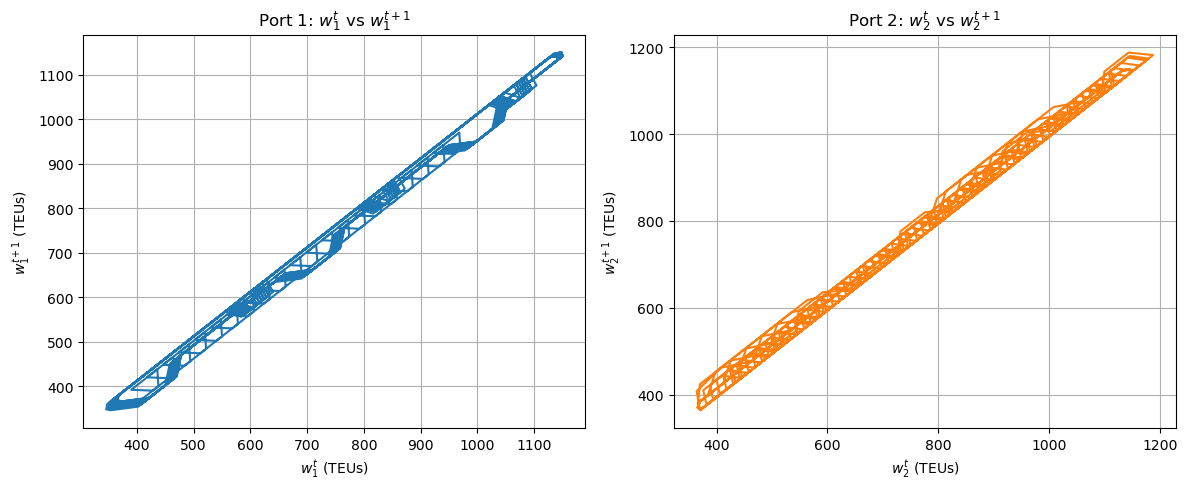

In [187]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Port 1: w1[t] vs w1[t+1]
ax1.plot(w1[:-1], w1[1:], color='tab:blue')
ax1.set_xlabel(r'$w_1^t$ (TEUs)')
ax1.set_ylabel(r'$w_1^{t+1}$ (TEUs)')
ax1.set_title(r'Port 1: $w_1^t$ vs. $w_1^{t+1}$')
ax1.grid(True)

# Port 2: w2[t] vs w2[t+1]
ax2.plot(w2[:-1], w2[1:], color='tab:orange')
ax2.set_xlabel(r'$w_2^t$ (TEUs)')
ax2.set_ylabel(r'$w_2^{t+1}$ (TEUs)')
ax2.set_title(r'Port 2: $w_2^t$ vs. $w_2^{t+1}$')
ax2.grid(True)

plt.tight_layout()
# plt.savefig('Two_Port_Return_Map.pdf')
plt.show()


In [183]:
def detect_limit_cycle(w1, w2, precision=6, min_period=12, max_period=3900):
    """
    Detects a repeating cycle (limit cycle) in the (w1, w2) time series.

    Args:
        w1, w2: arrays of warehouse levels over time
        precision: decimal rounding to reduce floating-point noise
        min_period: minimum candidate cycle length to check
        max_period: maximum cycle length to consider

    Returns:
        Tuple (transient_length, period) if a consistent cycle is found;
        otherwise, returns None.
    """
    from collections import defaultdict

    # Round state values to mitigate noise
    state_series = [
        (round(w1[t], precision), round(w2[t], precision))
        for t in range(len(w1))
    ]

    # Map state → time indices where it appears
    state_index = defaultdict(list)
    for t, state in enumerate(state_series):
        state_index[state].append(t)

    # Check for consistent spacing (potential period)
    for state, times in state_index.items():
        if len(times) >= 2:
            for i in range(len(times) - 1):
                start = times[i]
                period = times[i + 1] - start

                if not (min_period <= period <= max_period):
                    continue

                # Confirm repetition across multiple cycles
                match = True
                for j in range(1, 5):  # test 5 cycles
                    t1 = start
                    t2 = start + j * period
                    if t2 >= len(state_series):
                        match = False
                        break
                    if state_series[t1] != state_series[t2]:
                        match = False
                        break

                if match:
                    return start, period

    return None

# Run
result = detect_limit_cycle(w1, w2)

if result:
    transient, period = result
    print(f"Limit cycle detected after {transient} steps with period {period} steps.")
else:
    print("No consistent limit cycle detected in the given range.")


Limit cycle detected after 2049 steps with period 3900 steps.
